In [1]:
from PIL import Image
from aug_isic import ImgTrainTransform0, ImgTrainTransform1, ImgTrainTransform2, ImgTrainTransform21, ImgTrainTransform22, ImgTrainTransform3, ImgTrainTransform4, ImgEvalTransform, ImgTrainTransformWithPP
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline


<PIL.Image.Image image mode=RGB size=4419x4419 at 0x7F4317514C90>


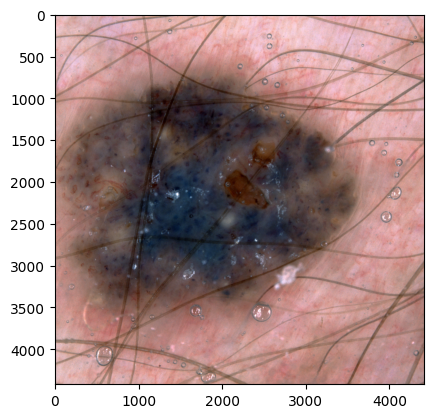

In [10]:
path = "/home/a52550/Desktop/datasets/ISIC2017/train/cropped_images/ISIC_0015182.jpg" #ISIC_0010847.jpg"
# path = "/home/a52550/Desktop/datasets/ISIC2017/train/cropped_images/ISIC_0014933.jpg"

image = Image.open(path).convert('RGB')
plt.imshow(image)
print(image)

In [ ]:
_data_augmentation = False
_PP_enhancement = None
_PP_hair_removal = None
_PP_color_constancy = None
_PP_denoising = None
_PP_normalization = True
_PP_crop_mode = None
_PP_resizing = True

f, ax = plt.subplots(3, 3, figsize=(10, 5))
transform = ImgTrainTransformWithPP()
x = transform(image)
ax[0, 0].imshow(x.permute(1,2,0))
ax[0, 0].set_title('Original')
transform = ImgEvalTransform()
x = transform(image)
ax[0, 1].imshow(x.permute(1,2,0))
ax[0, 1].set_title('Original')
transform = ImgTrainTransformWithPP(pp_enhancement='CLAHE')
x = transform(image)
ax[0, 2].imshow(x.permute(1,2,0))
ax[0, 2].set_title('CLAHE')
transform = ImgTrainTransformWithPP(pp_hair_removal='dull_razor')
x = transform(image)
ax[1, 0].imshow(x.permute(1,2,0))
ax[1, 0].set_title('Dull Razor')
transform = ImgTrainTransformWithPP(pp_color_constancy='shades_of_gray')
x = transform(image)
ax[1, 1].imshow(x.permute(1,2,0))
ax[1, 1].set_title('Shades of Gray')
transform = ImgTrainTransformWithPP(pp_denoising='mean_filter')
x = transform(image)
ax[2, 1].imshow(x.permute(1,2,0))
ax[2, 1].set_title('Mean Filter')
transform = ImgTrainTransformWithPP(pp_denoising='non_local_means')
x = transform(image)
ax[2, 0].imshow(x.permute(1,2,0))
ax[2, 0].set_title('Non Local Means')
transform = ImgTrainTransformWithPP(pp_denoising='gaussian_filter')
x = transform(image)
ax[2, 2].imshow(x.permute(1,2,0))
ax[2, 2].set_title('Gaussian Filter')

plt.show()

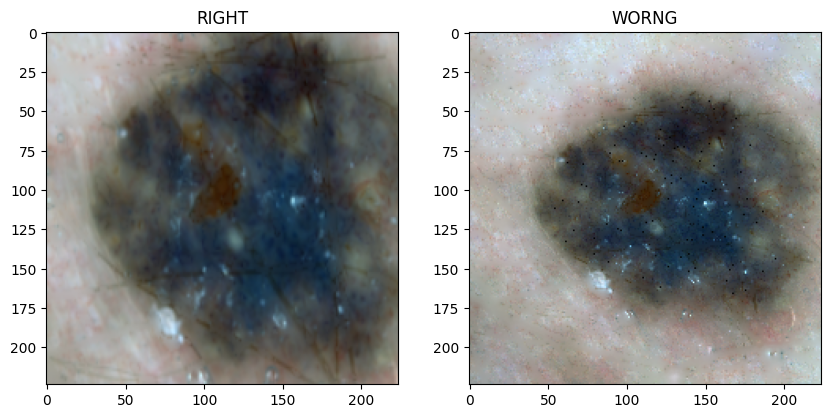

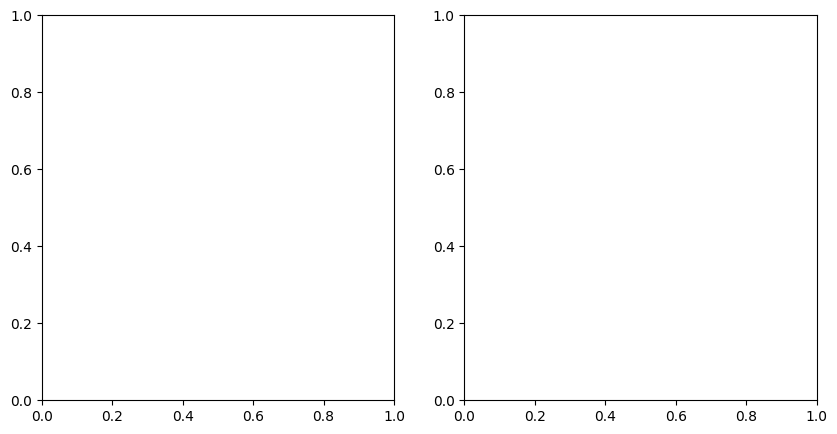

In [84]:
transform = ImgTrainTransform21( pp_hair_removal = 'dull_razor', pp_color_constancy = 'shades_of_gray')
# convert image to numpy array
x = transform(image)

# convert Image data of dtype object to float
# plt.imshow(x.permute(1,2,0))

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x.permute(1,2,0))
ax[0].set_title('RIGHT')

transform = ImgTrainTransform2( pp_hair_removal = 'dull_razor', pp_color_constancy = 'shades_of_gray')
# convert image to numpy array
x = transform(image)

# convert Image data of dtype object to float
# plt.imshow(x.permute(1,2,0))


ax[1].imshow(x.permute(1,2,0))
ax[1].set_title('WORNG')

f, ax = plt.subplots(1, 2, figsize=(10, 5))


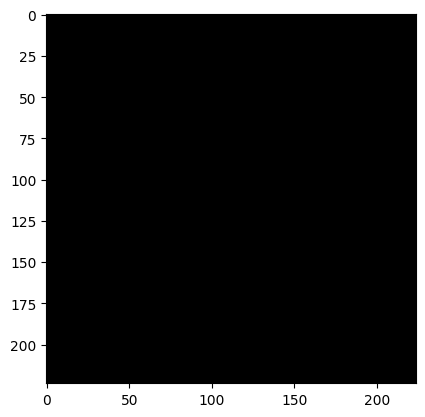

In [43]:
# correct error: Invalid number of channels in input image:
# >     'VScn::contains(scn)'
# > where
# >     'scn' is 224

x = image_preprocessing(np.array(x.permute(1,2,0), dtype=np.uint8),pp_enhancement=None, pp_hair_removal='dull_razor',pp_color_constancy=None,pp_denoising=None)

plt.imshow(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


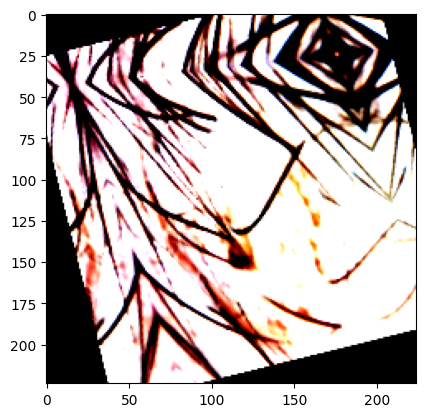

In [4]:
transform = ImgTrainTransform4()
# convert image to numpy array
x = transform(np.array(image, dtype=np.uint8))

# convert Image data of dtype object to float
plt.imshow(x.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.7077,  0.7419,  0.7591,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.6392,  0.6906,  0.7591,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.6049,  0.6563,  0.7419,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[ 0.5028,  0.5203,  0.6078,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.4503,  0.4853,  0.5728,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.4153,  0.4503,  0.5553,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[ 0.6182,  0.6356,  0.7054,  ..., -1.8044, -1.8044, -1.8044],
         [ 0.5485,  0.6008,  0.6879,  ..., -1

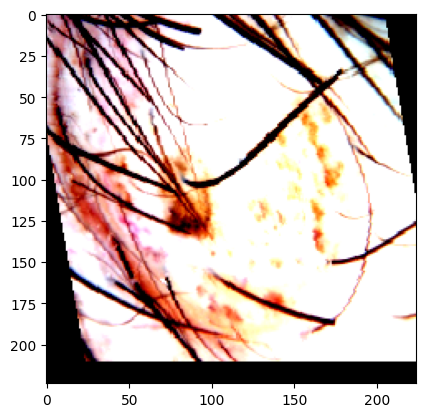

In [22]:
transform = ImgTrainTransform3()
x = transform(image)
plt.imshow(x.permute(1,2,0))
print(x)